In [1]:
import numpy as np
from qulacs import QuantumState, QuantumCircuit
from scipy.optimize import minimize
from functools import reduce
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### No of qubit and other params

In [2]:
n_qubit = 5
cn = 1
bn = 1
gamma = 1

### Create XY Hamiltonian

$H=1/2 \sum_{n=1}^{N-1}c_n[(1+\gamma)X_nX_{n+1}+(1-\gamma)Y_nY_{n+1}]+\sum_{n=1}^{N}B_nZ_n$

In [3]:
from openfermion.ops import QubitOperator
from qulacs.observable import create_observable_from_openfermion_text
def create_xy_hamiltonian(nqubit, cn, bn, r):
    hami = QubitOperator()
    for i in range(nqubit-1):
        hami += (0.5*cn*(1+r)) * QubitOperator(f"X{i} X{i+1}")
        hami += (0.5*cn*(1-r)) * QubitOperator(f"Y{i} Y{i+1}")
    for j in range(nqubit):
        hami += bn*QubitOperator(f"Z{j}")

    return (create_observable_from_openfermion_text(str(hami)))

xy_hamiltonian = create_xy_hamiltonian(n_qubit, cn, bn, gamma)

### Create Ansatz

In [4]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

depth = n_qubit

In [5]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))

    return circuit

### Cost function

In [6]:
def cost(theta_list):
    state = QuantumState(n_qubit) #Prepare |00000>
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #Construct quantum circuit
    circuit.update_quantum_state(state) #Operate quantum circuit on state
    return xy_hamiltonian.get_expectation_value(state) #Calculate expectation value of Hamiltonian

### Run VQE

In [7]:
cost_history = []
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

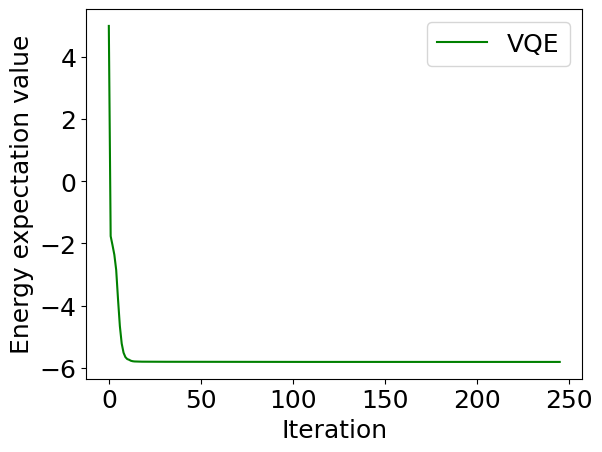

In [15]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="green", label="VQE")
#plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

### Cost function

In [9]:
print(cost_history)

[4.991319110563752, -1.7656494349591094, -2.0550760736207394, -2.3635427472501194, -2.8501079266668157, -3.7968790419690372, -4.656265472543101, -5.218312557322362, -5.5114121293083524, -5.652104128914641, -5.715255796895745, -5.7382201997030675, -5.770440497052182, -5.785665250821047, -5.792828249913591, -5.795165008642737, -5.796550067519458, -5.798317436143744, -5.7999145780998855, -5.800409575383409, -5.800480796679453, -5.8006139802579515, -5.800858820284233, -5.801283835837715, -5.801897460011082, -5.802338041361834, -5.802565584339619, -5.802770452234781, -5.802797369340089, -5.802840988662311, -5.802903000824414, -5.802966780567889, -5.8030706852563325, -5.803211044844418, -5.803288108960652, -5.803353976297404, -5.803402593195008, -5.8034570147502835, -5.80349931148086, -5.803524021483377, -5.803538720485081, -5.803550523106947, -5.803560611071244, -5.803567168441382, -5.803570046784122, -5.803571778066333, -5.803573984912809, -5.803577059817286, -5.803581559863753, -5.8035873